In [37]:
import numpy as np
import pandas as pd
from wgan import WGAN
from sklearn.preprocessing import RobustScaler, StandardScaler
import tensorflow as tf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import seaborn as sns
from fredapi import Fred

sns.set(style="whitegrid")

# Data Preparation
def get_stock_data(ticker, start_date, end_date, tweets_df):
    # data = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\aapl_stocks_2015_2019.csv')
    data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Merge with tweet data
    tweets_df = tweets_df[tweets_df['ticker_symbol'] == ticker]
    tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
    combined_data = pd.merge(stock_data.reset_index(), tweets_df[['date', 'avg_negative_sentiment', 'avg_reach_per_tweet']], 
                             left_on='Date', right_on='date', how='left')
    combined_data.set_index('Date', inplace=True)
    combined_data = combined_data.drop('date', axis=1)
    
    # Forward fill missing sentiment values
    combined_data['avg_negative_sentiment'] = combined_data['avg_negative_sentiment'].ffill()
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    combined_data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(combined_data.index, method='ffill')
    # combined_data['consumer_sentiment'] = fred.get_series('UMCSENT').reindex(combined_data.index, method='ffill')

    return combined_data

# Model Definitions
# SIMPLE MODEL L2
# def make_generator_model(noise_dim, sequence_length, num_features):
#     n = 128 # 128
#     l2_val = 0.0

#     model = keras.Sequential([
#         keras.layers.Dense(n * sequence_length, input_shape=(noise_dim,), kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.Reshape((sequence_length, n)),
#         keras.layers.Conv1D(n//2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(n//4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(num_features, kernel_size=3, padding='same', activation='tanh', dtype=tf.float32)
#     ])
#     return model

# SIMPLE MODEL
def make_generator_model(noise_dim, sequence_length, num_features):
    n = 128 # 128

    model = keras.Sequential([
        keras.layers.Dense(n * sequence_length, input_shape=(noise_dim,), dtype=tf.float32),
        keras.layers.Reshape((sequence_length, n)),
        keras.layers.Conv1D(n//2, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(n//4, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(num_features, kernel_size=3, padding='same', activation='tanh', dtype=tf.float32)
    ])
    return model

# COMPLEX MODEL L2
# def make_generator_model(noise_dim, sequence_length, num_features):
#     n = 256
#     l2_val = 0.01
#     model = keras.Sequential([
#         keras.layers.Dense(n * sequence_length, input_shape=(noise_dim,), 
#                            kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.Reshape((sequence_length, n)),
#         keras.layers.Conv1D(n//2, kernel_size=3, padding='same', 
#                             kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(n//4, kernel_size=3, padding='same', 
#                             kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(n//8, kernel_size=3, padding='same', 
#                             kernel_regularizer=regularizers.l2(l2_val), dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(num_features, kernel_size=3, padding='same', activation='tanh', dtype=tf.float32)
#     ])
#     return model

# COMPLEX MODEL
# def make_generator_model(noise_dim, sequence_length, num_features):
#     n = 256
#     model = keras.Sequential([
#         keras.layers.Dense(n * sequence_length, input_shape=(noise_dim,), dtype=tf.float32),
#         keras.layers.Reshape((sequence_length, n)),
#         keras.layers.Conv1D(n//2, kernel_size=3, padding='same', dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         # Added extra layer
#         keras.layers.Conv1D(n//4, kernel_size=3, padding='same', dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(n//8, kernel_size=3, padding='same', dtype=tf.float32),
#         keras.layers.LeakyReLU(alpha=0.2),
#         keras.layers.Conv1D(num_features, kernel_size=3, padding='same', activation='tanh', dtype=tf.float32)
#     ])
#     return model


def make_critic_model(sequence_length, num_features):
    model = keras.Sequential([
        keras.layers.Conv1D(32, kernel_size=3, padding='same', input_shape=(sequence_length, num_features), dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(128, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(1, dtype=tf.float32)
    ])
    return model



In [38]:
def preprocess_data(data, sequence_length, price_columns, non_price_columns):
    # Separate price and non-price data
    price_data = data[price_columns]
    non_price_data = data[non_price_columns]
    
    # Log transform and difference price data
    log_price_data = np.log(price_data).diff().dropna()
    
    # Keep non-price data as is, just align with price data
    aligned_non_price_data = non_price_data.iloc[1:]  # Remove first row to align with differenced price data
    
    # Align the data
    aligned_data = pd.concat([log_price_data, aligned_non_price_data], axis=1)
    aligned_data.dropna(inplace=True)
    # Scale the data
    price_scaler = MinMaxScaler(feature_range=(-1, 1))
    non_price_scaler = MinMaxScaler(feature_range=(-1, 1))
    # non_price_scaler = RobustScaler()
    
    scaled_price_data = price_scaler.fit_transform(aligned_data[price_columns])
    scaled_non_price_data = non_price_scaler.fit_transform(aligned_data[non_price_columns])
    
    # Combine scaled data
    scaled_data = np.hstack((scaled_price_data, scaled_non_price_data)).astype(np.float32)
    
    # Create sequences
    sequences = []
    for i in range(len(scaled_data) - sequence_length + 1):
        sequences.append(scaled_data[i:i+sequence_length])
    
    return np.array(sequences), (price_scaler, non_price_scaler), data.iloc[-len(aligned_data):]

def generate_synthetic_data(generator, noise_dim, num_samples, sequence_length, num_features, scalers, last_real_data, price_columns, non_price_columns):
    price_scaler, non_price_scaler = scalers
    
    print(f"Generating {num_samples} samples with {num_features} features")
    
    noise = tf.random.normal([num_samples, noise_dim], dtype=tf.float32)
    synthetic_sequences = generator(noise, training=False)
    print(f"Generator output shape: {synthetic_sequences.shape}")
    
    # Take the last step of each sequence
    synthetic_changes = synthetic_sequences[:, -1, :]
    print(f"Synthetic changes shape: {synthetic_changes.shape}")
    
    # Separate price and non-price synthetic data
    num_price_columns = len(price_columns)
    synthetic_price_changes = synthetic_changes[:, :num_price_columns]
    synthetic_non_price_values = synthetic_changes[:, num_price_columns:]
    
    # Inverse transform
    synthetic_price_log_changes = price_scaler.inverse_transform(synthetic_price_changes)
    synthetic_non_price_values = non_price_scaler.inverse_transform(synthetic_non_price_values)
    
    # Generate synthetic prices
    last_prices = last_real_data[price_columns].iloc[-1].values
    synthetic_prices = last_prices * np.exp(np.cumsum(synthetic_price_log_changes, axis=0))
    
    # Combine synthetic data
    synthetic_data = np.column_stack((synthetic_prices, synthetic_non_price_values))
    synthetic_df = pd.DataFrame(synthetic_data, columns=price_columns + non_price_columns)
    
    print(f"Synthetic DataFrame shape: {synthetic_df.shape}")
    
    # Set the index for the synthetic data
    last_date = last_real_data.index[-1]
    synthetic_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_samples, freq='D')
    synthetic_df.index = synthetic_index
    
    return synthetic_df

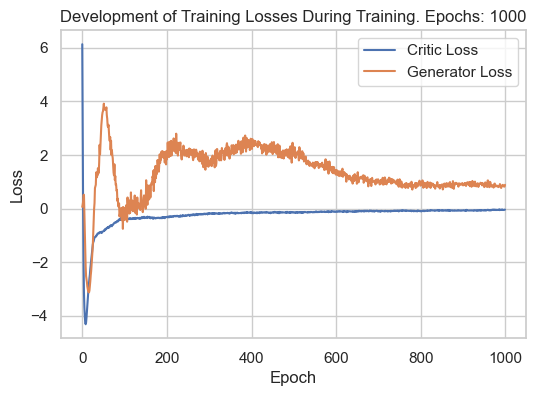

Epoch 1000, Critic Loss: -0.0406, Generator Loss: 0.8829
Generating 300 samples with 5 features
Generator output shape: (300, 30, 5)
Synthetic changes shape: (300, 5)
Synthetic DataFrame shape: (300, 5)


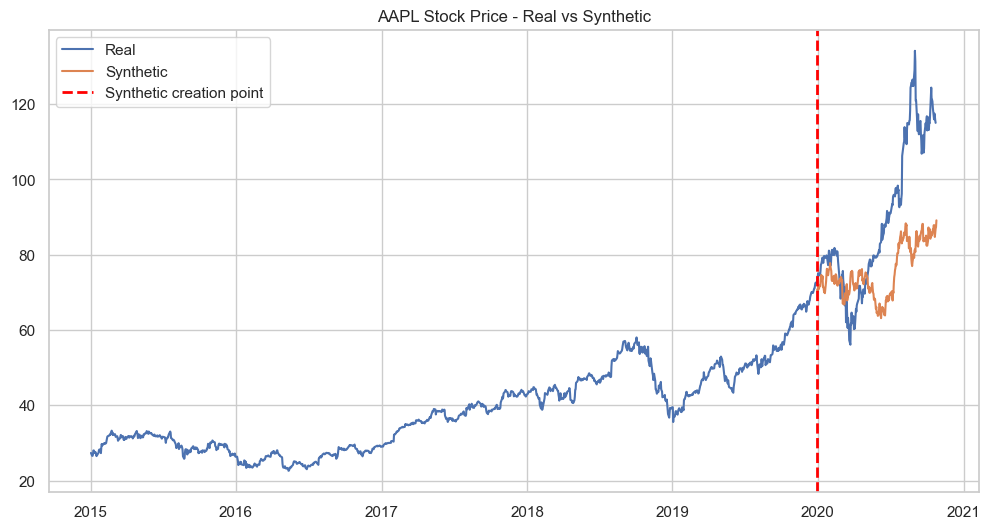

In [53]:
import keyboard
def setup_keyboard_interrupt(model):
    keyboard.add_hotkey('ctrl+shift+q', wgan.stop_training)
    keyboard.add_hotkey('ctrl+shift+e', wgan.continue_training)

# Main execution
if __name__ == "__main__":
    # Parameters
    ticker = "AAPL"
    start_date = "2015-01-01"
    end_date = "2019-12-31"
    # HIGHER SEQ LENGTH MIGHT IMPROVE CONTINUITY TRANSFORMATION CUMULATIVE ERRORS _____________________________________  
    # HIGHER BATCHES MAY BE BETTER/STABLE. LOWER TO FIT MORE
    sequence_length = 30
    noise_dim = 100
    batch_size = 128 
    epochs = 1000
    samples = 300

    tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\volume.csv')
    
    # Get and preprocess data
    stock_data = get_stock_data(ticker, start_date, end_date, tweets_df)

    date_obj = datetime.strptime(end_date, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=samples)
    new_end_date = new_date_obj.strftime("%Y-%m-%d")

    # Get and preprocess data
    new_stock_data = get_stock_data(ticker, start_date, new_end_date, tweets_df)
   
    # PRICE_COLUMNS = ['Open', 'High', 'Low', 'Close']
    PRICE_COLUMNS = ['Close']
    NON_PRICE_COLUMNS = ['Volume', 'avg_negative_sentiment', 'avg_reach_per_tweet', 'inflation_rate']
    # NON_PRICE_COLUMNS = ['Volume']
    stock_data = stock_data[PRICE_COLUMNS+NON_PRICE_COLUMNS]

    sequences, scaler, last_prices = preprocess_data(stock_data, sequence_length, PRICE_COLUMNS, NON_PRICE_COLUMNS)
    
    num_features = sequences.shape[2]
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(sequences).shuffle(1000).batch(batch_size)
    
    # Create models
    generator = make_generator_model(noise_dim, sequence_length, num_features)
    critic = make_critic_model(sequence_length, num_features)

    wgan = WGAN(generator, critic, noise_dim, critic_extra_steps=3, gp_weight=10.0, c_lr=1e-4, g_lr=5e-5)
#    wgan = WGAN(generator, critic, noise_dim, critic_extra_steps=5, gp_weight=20.0, c_lr=7e-4, g_lr=1e-5)

    setup_keyboard_interrupt(wgan)

    wgan.train(dataset, epochs)
    
    # synthetic_data = generate_synthetic_data(wgan.generator, noise_dim, samples, num_features, scaler, last_prices)

    # ________________________________________________________________________________
    last_prices = stock_data.iloc[-1:]
    synthetic_data = generate_synthetic_data(wgan.generator, noise_dim, samples, sequence_length, num_features, scaler, last_prices, PRICE_COLUMNS, NON_PRICE_COLUMNS)
    # ________________________________________________________________________________

    plt.figure(figsize=(12, 6))
    plt.plot(new_stock_data.index, new_stock_data['Close'].values, label='Real')
    plt.plot(synthetic_data.index, synthetic_data['Close'], label='Synthetic')
    plt.axvline(x=synthetic_data.index[0], color='red', linestyle='--', linewidth=2, label='Synthetic creation point')
    plt.title(f"{ticker} Stock Price - Real vs Synthetic")
    plt.legend()
    plt.show()

Generating 1257 samples with 5 features
Generator output shape: (1257, 30, 5)
Synthetic changes shape: (1257, 5)
Synthetic DataFrame shape: (1257, 5)
30


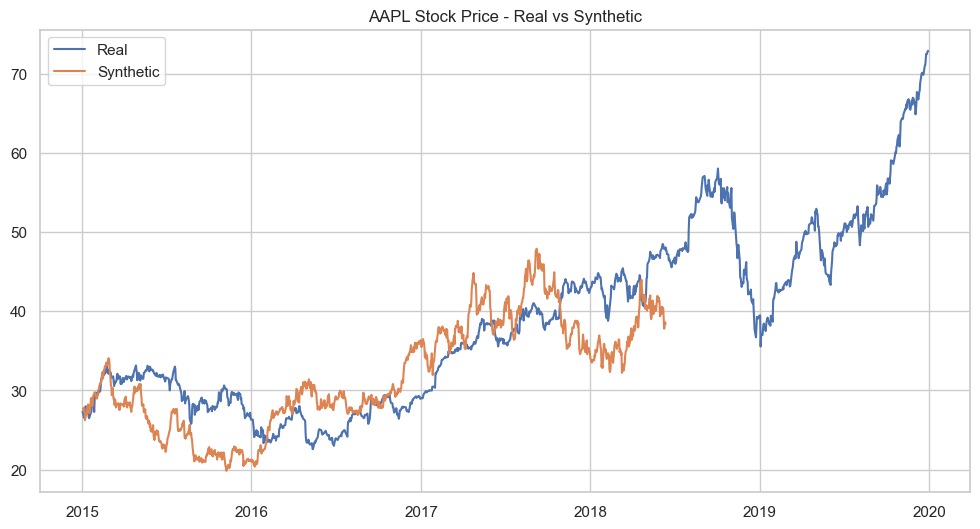

In [54]:

# Generate synthetic data
samples = len(stock_data)  
entire_synthetic_data = generate_synthetic_data(wgan.generator, noise_dim, samples, sequence_length, num_features, scaler, stock_data.iloc[:1], PRICE_COLUMNS, NON_PRICE_COLUMNS)
print(sequence_length)
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'].values, label='Real')
plt.plot(entire_synthetic_data.index, entire_synthetic_data['Close'], label='Synthetic')
plt.title(f"{ticker} Stock Price - Real vs Synthetic")
plt.legend()
plt.show()


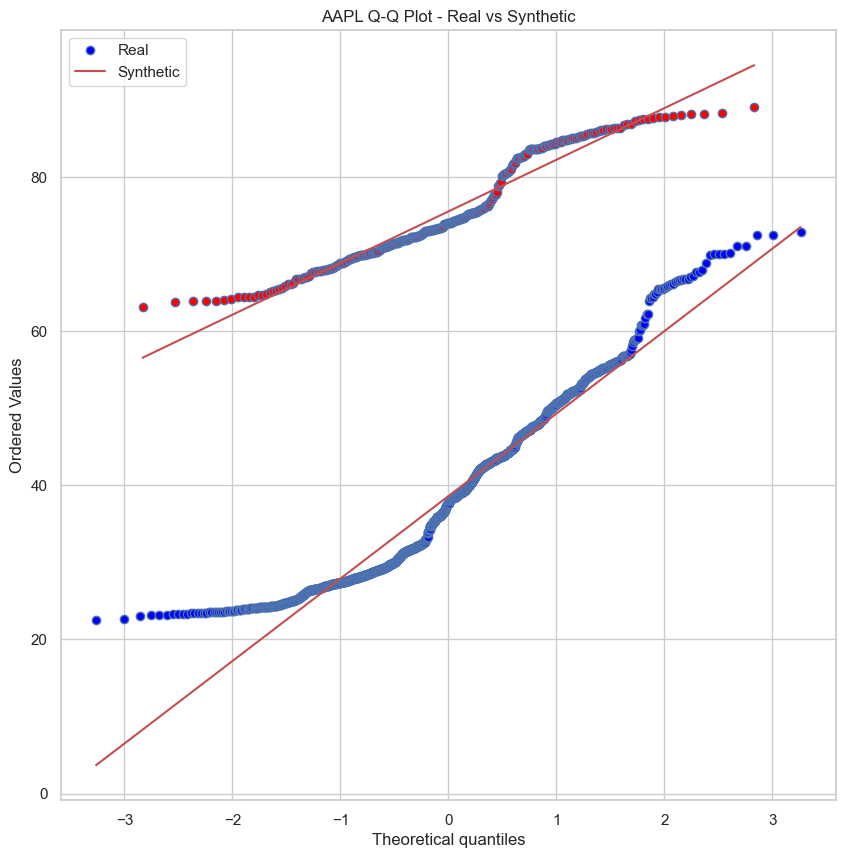

In [55]:
from scipy import stats

#_________________________________________________________________________________
# synthetic_data['Close'] = synthetic_data['Close'] - 40 
#_________________________________________________________________________________


fig, ax = plt.subplots(figsize=(10, 10))
stats.probplot(stock_data['Close'], dist="norm", plot=ax)
stats.probplot(synthetic_data['Close'], dist="norm", plot=ax)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[2].set_markerfacecolor('red')
ax.legend(["Real", "Synthetic"])
plt.title(f"{ticker} Q-Q Plot - Real vs Synthetic")
plt.show()

In [56]:
len(stock_data), len(synthetic_data)

(1257, 300)

C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_17356\4011127713.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_17356\4011127713.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


Returns Densities:


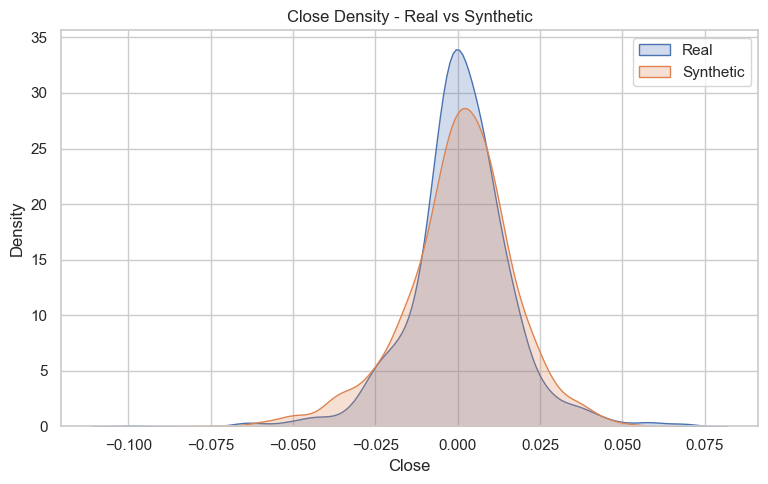

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def clean_data(data):
    # Replace inf with NaN
    data = data.replace([np.inf, -np.inf], np.nan)
    # Forward fill NaN values
    data = data.fillna(method='ffill')
    # If any NaNs remain at the beginning, back fill
    data = data.fillna(method='bfill')
    return data

def plot_densities(real_data, synthetic_data, columns):
    num_cols = len(columns)
    nrows = (num_cols + 1) // 2
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    axs = axs.flatten()

    for i, col in enumerate(columns):
        sns.kdeplot(real_data[col], label='Real', fill=True, ax=axs[i])
        sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True, ax=axs[i])
        axs[i].set_ylabel("Density")
        axs[i].legend()
        axs[i].set_title(f"{col} Density - Real vs Synthetic")

    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Clean and detrend the data
clean_real = clean_data(stock_data)
clean_synthetic = clean_data(entire_synthetic_data)

# Compare returns
real_returns = clean_real.pct_change().dropna()
synthetic_returns = clean_synthetic.pct_change().dropna()

print("Returns Densities:")
plot_densities(real_returns, synthetic_returns, ['Close'])

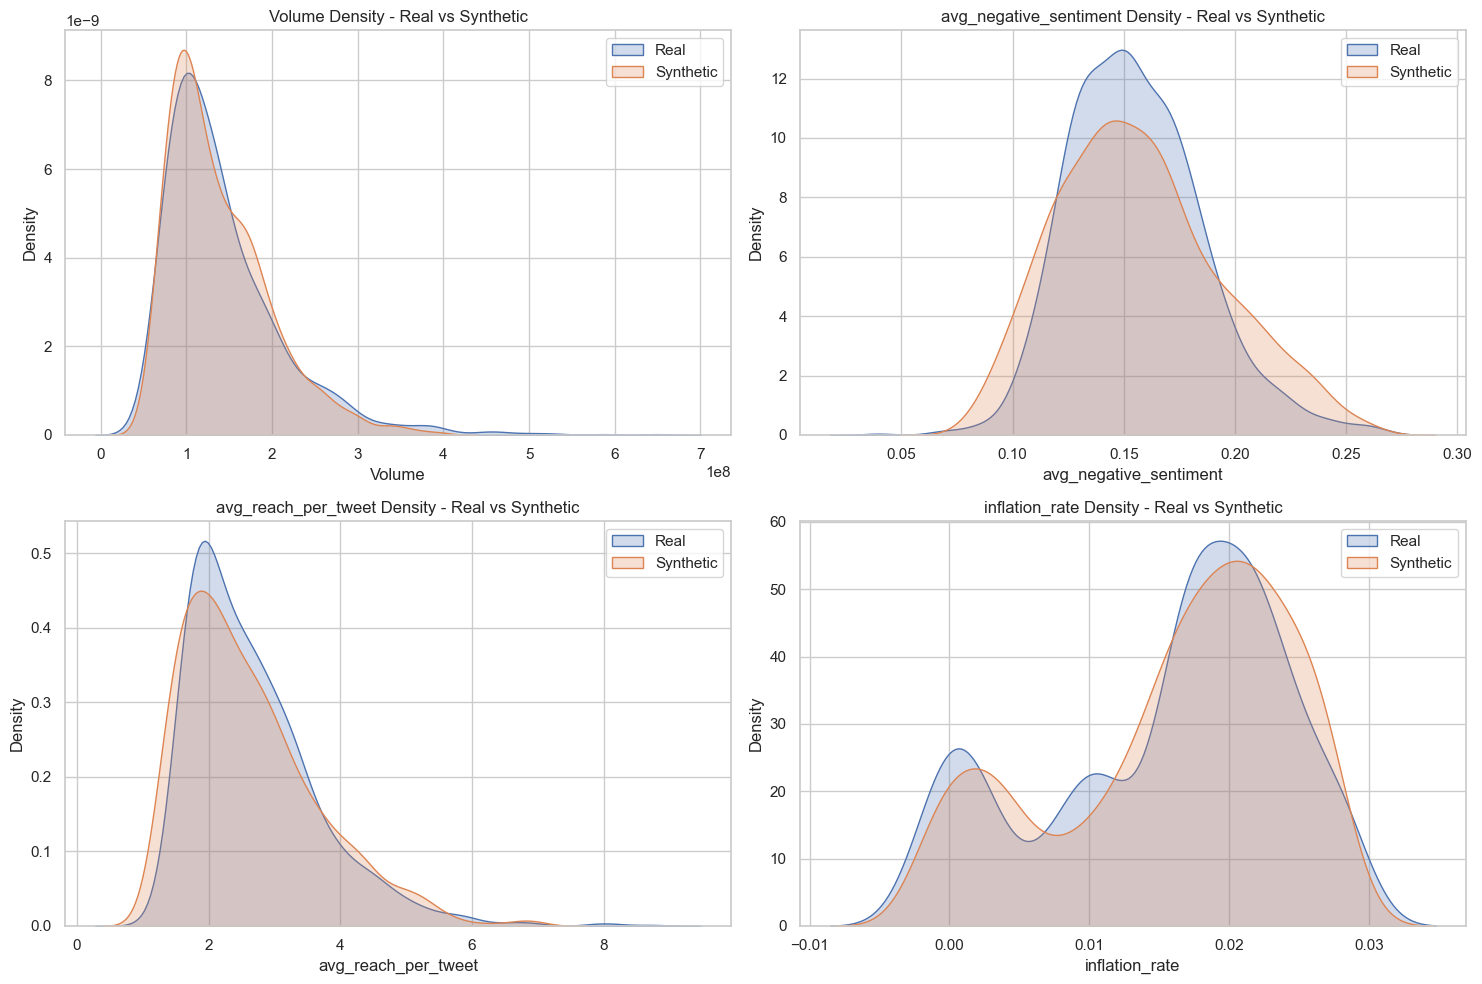

In [58]:
plot_densities(clean_real, clean_synthetic, stock_data.columns.drop(PRICE_COLUMNS))

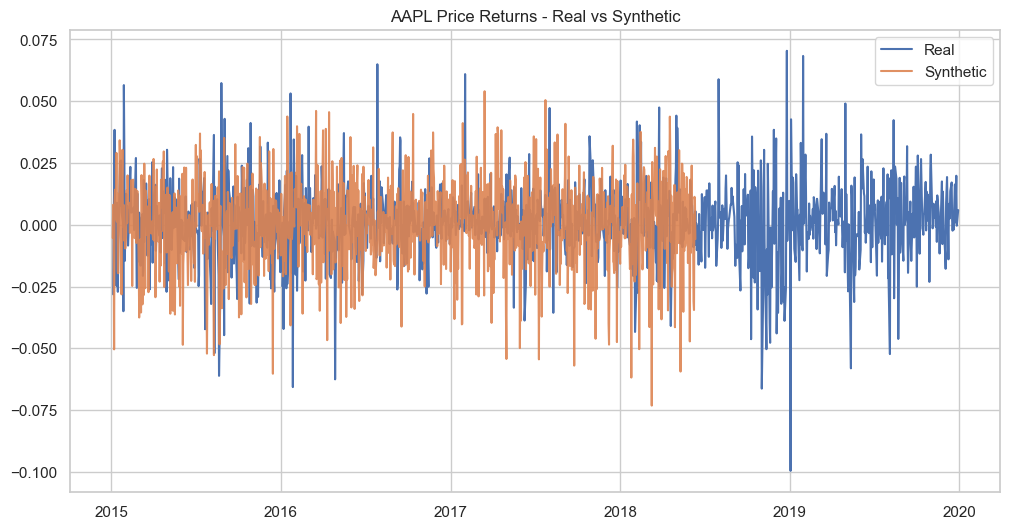

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(real_returns['Close'], label='Real')
plt.plot(synthetic_returns['Close'], label='Synthetic', alpha=0.9)
plt.title(f"{ticker} Price Returns - Real vs Synthetic")
plt.legend()
plt.show()

In [60]:
from scipy import stats
from termcolor import colored
from ptool import Tool
# Tool.email()

def evaluate(col):
    real_returns = stock_data[col].diff().dropna()
    synthetic_returns = entire_synthetic_data[col].diff().dropna()

    # Kolmogorov-Smirnov test
    ks_statistic, ks_pvalue = stats.ks_2samp(real_returns, synthetic_returns)
    print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={ks_pvalue:.4f}")

    if ks_pvalue > 0.05:
        print(colored(f"SIMILAR: {ks_pvalue:.4f}",  "green"))
        for _ in range(4):
            Tool.sound(300,500)     
    else: 
        print(colored(f"NOT SIMILAR: {ks_pvalue:.4f}",  "red"))
        Tool.sound(400, 50)
        
    # Anderson-Darling test
    ad_statistic, ad_critical_values, ad_significance_level = stats.anderson_ksamp([real_returns, synthetic_returns])
    print(f"Anderson-Darling test: statistic={ad_statistic:.4f}, significance level={ad_significance_level:.4f}")
    if ks_pvalue > 0.05:
        print(colored(f"SIMILAR: {ad_significance_level:.4f}",  "green"))
    else: 
        print(colored(f"NOT SIMILAR: {ad_significance_level:.4f}",  "red"))
# for col in stock_data.columns:
    # evaluate(col)

evaluate('Close')

Kolmogorov-Smirnov test: statistic=0.0287, p-value=0.6808
SIMILAR: 0.6808
Anderson-Darling test: statistic=0.2347, significance level=0.2500
SIMILAR: 0.2500


C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_17356\2446842489.py:23: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_statistic, ad_critical_values, ad_significance_level = stats.anderson_ksamp([real_returns, synthetic_returns])


In [61]:
from termcolor import colored
from ptool import Tool
from scipy import stats

real_returns = stock_data['Close'].pct_change().dropna()
synthetic_returns = entire_synthetic_data['Close'].pct_change().dropna()

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = stats.ks_2samp(real_returns, synthetic_returns)
print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={ks_pvalue:.4f}")

if ks_pvalue > 0.05:
    print(colored(f"SIMILAR: {ks_pvalue:.4f}",  "green"))
    for _ in range(4):
        Tool.sound(700,200)
else: 
    print(colored(f"NOT SIMILAR: {ks_pvalue:.4f}",  "red"))
    Tool.sound(400,100)
    
# Anderson-Darling test
ad_statistic, ad_critical_values, ad_significance_level = stats.anderson_ksamp([real_returns, synthetic_returns])
print(f"Anderson-Darling test: statistic={ad_statistic:.4f}, significance level={ad_significance_level:.4f}")
if ad_significance_level > 0.05:
    print(colored(f"SIMILAR: {ad_significance_level:.4f}",  "green"))
else: 
    print(colored(f"NOT SIMILAR: {ad_significance_level:.4f}",  "red"))


Kolmogorov-Smirnov test: statistic=0.0510, p-value=0.0767
SIMILAR: 0.0767
Anderson-Darling test: statistic=2.9090, significance level=0.0211
NOT SIMILAR: 0.0211


Real log returns shape: (1256,)
Synthetic log returns shape: (299,)


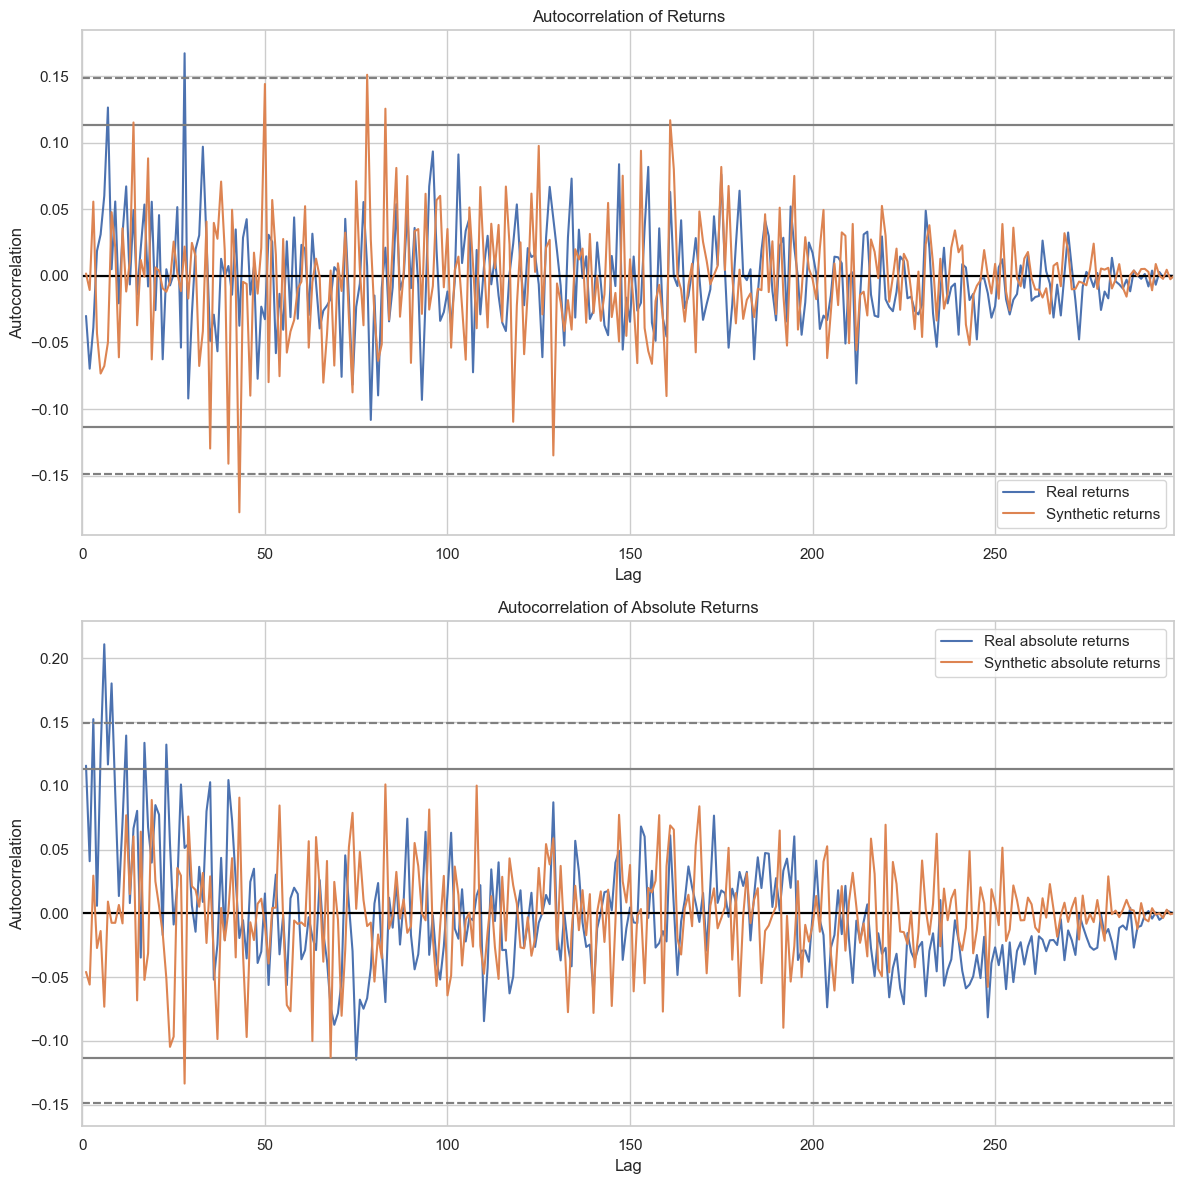

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd

def plot_autocorrelation(real_data, synthetic_data, max_lags=2000):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot autocorrelation of returns
    autocorrelation_plot(real_data, ax=ax1, label='Real returns')
    autocorrelation_plot(synthetic_data, ax=ax1, label='Synthetic returns')
    ax1.set_xlim([0, max_lags])
    ax1.set_title('Autocorrelation of Returns')
    ax1.legend()
    
    # Plot autocorrelation of absolute returns
    autocorrelation_plot(np.abs(real_data), ax=ax2, label='Real absolute returns')
    autocorrelation_plot(np.abs(synthetic_data), ax=ax2, label='Synthetic absolute returns')
    ax2.set_xlim([0, max_lags])
    ax2.set_title('Autocorrelation of Absolute Returns')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Ensure synthetic_data is a DataFrame with a 'Close' column
if isinstance(synthetic_data, np.ndarray):
    synthetic_data = pd.DataFrame(synthetic_data, columns=['Close'])

# Calculate log returns for real data
real_log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()

# Calculate log returns for synthetic data
synthetic_log_returns = np.log(synthetic_data['Close'] / synthetic_data['Close'].shift(1)).dropna()

# Print shapes for debugging
print(f"Real log returns shape: {real_log_returns.shape}")
print(f"Synthetic log returns shape: {synthetic_log_returns.shape}")

# Trim the longer series to match the shorter one
min_length = min(len(real_log_returns), len(synthetic_log_returns))
real_log_returns = real_log_returns[-min_length:]
synthetic_log_returns = synthetic_log_returns[-min_length:]

# Plot autocorrelation
plot_autocorrelation(real_log_returns, synthetic_log_returns, max_lags=len(synthetic_log_returns))

____

In [4]:
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Permute, Multiply
from tensorflow.keras.regularizers import l2
import seaborn as sns
sns.set(style="whitegrid")


def attention_block(inputs):
    # Permute the dimensions of the input to (batch_size, time_steps, channels)
    a = Permute((2, 1))(inputs)
    # Dense layer to learn the attention weights
    a = Dense(inputs.shape[1], activation='softmax')(a)
    # Permute back to (batch_size, channels, time_steps)
    a = Permute((2, 1), name='attention_vec')(a)
    # Element-wise multiplication of inputs and attention weights
    outputs = Multiply()([inputs, a])
    return outputs

def attention(input_shape):
    l2_val = 1e-3

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_val))(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = attention_block(x)
    x = LSTM(50, activation='relu', return_sequences=False, kernel_regularizer=l2(l2_val))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, kernel_regularizer=l2(l2_val))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=['mae'])
    return model


# WITH TECHNICAL INDICATORS

[*********************100%%**********************]  1 of 1 completed
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\3505753150.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\3505753150.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
C:\Users\Adi

MSE for Model 1 (AAPL real + synthetic): [0.006388750858604908, 0.08808311074972153]
MSE for Model 2 (AAPL real only): [2.630711317062378, 3.1292996406555176]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


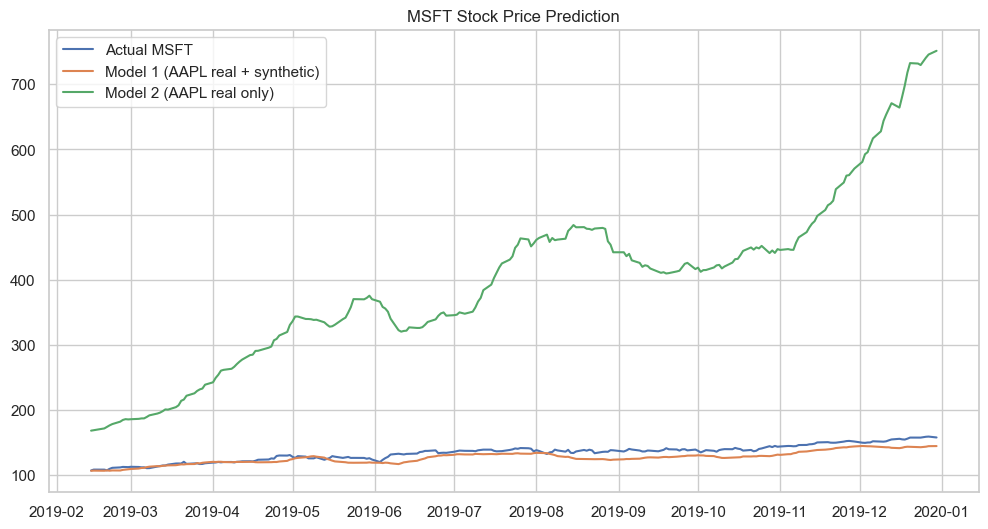

MAE for Model 1 (AAPL real + synthetic): 7.3675
MAE for Model 2 (AAPL real only): 261.7421
RMSE for Model 1 (AAPL real + synthetic): 8.6240
RMSE for Model 2 (AAPL real only): 287.1168
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━

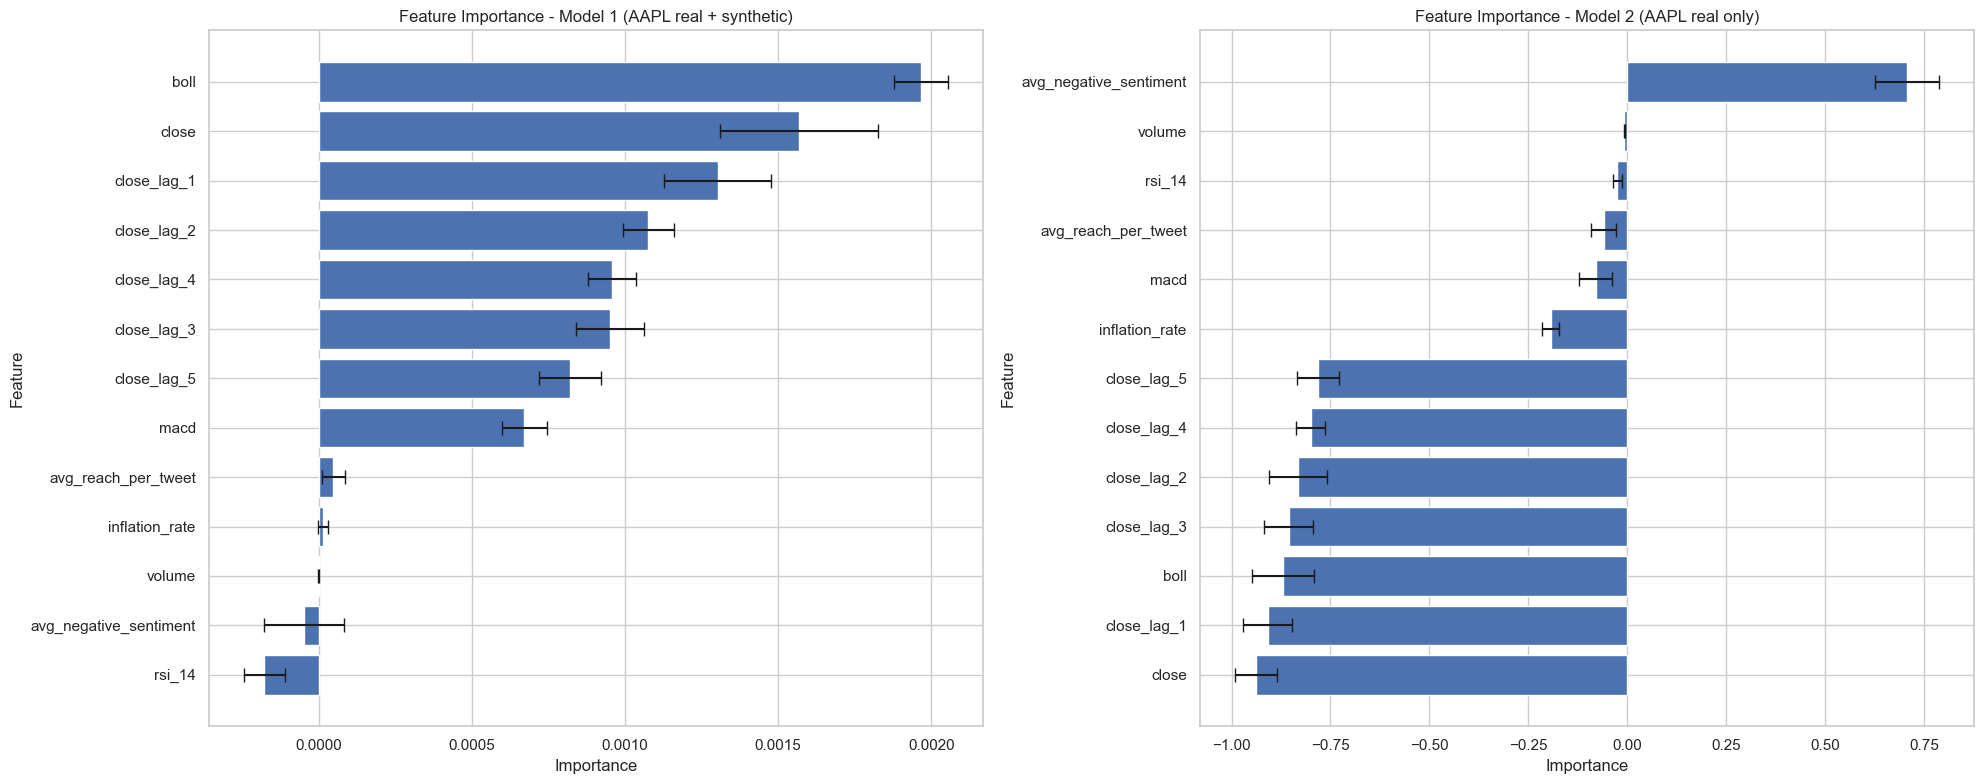

In [6]:

# With technical indicators
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from fredapi import Fred
import matplotlib.pyplot as plt
from stockstats import StockDataFrame
import seaborn as sns 
sns.set_style('whitegrid')

def add_lagged_values(data, column, lags):
    for i in range(1, lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

def get_stock_data(ticker, start_date, end_date, tweets_df):
    data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = data[['Close', 'Volume']].copy()
    stock_data.columns = stock_data.columns.str.lower()  # Convert to lowercase
    
    # Add StockStats indicators
    stock = StockDataFrame.retype(stock_data)
    indicators = ['rsi_14', 'macd', 'boll']
    for indicator in indicators:
        stock_data[indicator] = stock[indicator]
    
    # Add lagged close values
    stock_data = add_lagged_values(stock_data, 'close', 5)
    
    tweets_df = tweets_df[tweets_df['ticker_symbol'] == ticker]
    tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
    combined_data = pd.merge(stock_data.reset_index(), tweets_df[['date', 'avg_negative_sentiment', 'avg_reach_per_tweet']], 
                             left_on='Date', right_on='date', how='left')
    combined_data.set_index('Date', inplace=True)
    combined_data = combined_data.drop('date', axis=1)
    
    combined_data['avg_negative_sentiment'] = combined_data['avg_negative_sentiment'].ffill()
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    combined_data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(combined_data.index, method='ffill')
    
    return combined_data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Assuming 'close' is at index 0
    return np.array(X), np.array(y)

def create_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

EPOCHS = 50

# Load tweet data
tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\volume.csv')

# Prepare AAPL data (2015-2018)
aapl_data = get_stock_data("AAPL", "2015-01-01", "2018-12-31", tweets_df)
aapl_data.dropna(inplace=True)

# Load synthetic data (assuming it's already generated and saved)
synthetic_data = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\csvs\synth_data_2021-02-03.csv', index_col=0, parse_dates=True)
synthetic_data.columns = synthetic_data.columns.str.lower()  # Convert to lowercase

# Add StockStats indicators to synthetic data
synthetic_stock = StockDataFrame.retype(synthetic_data)
indicators = ['rsi_14', 'macd', 'boll']
for indicator in indicators:
    synthetic_data[indicator] = synthetic_stock[indicator]

# Add lagged close values to synthetic data
synthetic_data = add_lagged_values(synthetic_data, 'close', 5)

# Ensure synthetic_data has the same column order as aapl_data
synthetic_data = synthetic_data[aapl_data.columns]

# Combine real and synthetic AAPL data for Model 1
combined_aapl_data = pd.concat([aapl_data, synthetic_data])

# Fill NaN values in combined data
combined_aapl_data = combined_aapl_data.ffill().bfill()

# Prepare MSFT data (2019)
msft_data = get_stock_data("MSFT", "2019-01-01", "2019-12-31", tweets_df)

# Ensure all datasets have the same columns
columns_to_use = ['close', 'volume', 'rsi_14', 'macd', 'boll', 'avg_negative_sentiment', 'avg_reach_per_tweet', 'inflation_rate', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5']
aapl_data = aapl_data[columns_to_use]
combined_aapl_data = combined_aapl_data[columns_to_use]
msft_data = msft_data[columns_to_use]
msft_data.fillna(method="ffill", inplace=True)
msft_data.fillna(method="bfill", inplace=True)
# Scale the data
scaler = MinMaxScaler()
scaled_combined_aapl = scaler.fit_transform(combined_aapl_data)
scaled_aapl = scaler.transform(aapl_data)
scaled_msft = scaler.transform(msft_data)

# Prepare sequences
seq_length = 30
X_combined_aapl, y_combined_aapl = create_sequences(scaled_combined_aapl, seq_length)
X_aapl, y_aapl = create_sequences(scaled_aapl, seq_length)
X_msft, y_msft = create_sequences(scaled_msft, seq_length)

# Model 1: Train on real AAPL (2015-2018) + synthetic data
model1 = attention((seq_length, scaled_combined_aapl.shape[1]))
model1.fit(X_combined_aapl, y_combined_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

# Model 2: Train on real AAPL (2015-2018) only
model2 = attention((seq_length, scaled_aapl.shape[1]))
model2.fit(X_aapl, y_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

# Out-of-sample testing on MSFT data (2019)
mse_model1 = model1.evaluate(X_msft, y_msft, verbose=0)
mse_model2 = model2.evaluate(X_msft, y_msft, verbose=0)

print(f"MSE for Model 1 (AAPL real + synthetic): {mse_model1}")
print(f"MSE for Model 2 (AAPL real only): {mse_model2}")

# Make predictions
pred_model1 = model1.predict(X_msft)
pred_model2 = model2.predict(X_msft)

# Inverse transform predictions
pred_model1 = scaler.inverse_transform(np.column_stack((pred_model1, np.zeros((pred_model1.shape[0], len(columns_to_use)-1)))))[:, 0]
pred_model2 = scaler.inverse_transform(np.column_stack((pred_model2, np.zeros((pred_model2.shape[0], len(columns_to_use)-1)))))[:, 0]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(msft_data.index[seq_length:], msft_data['close'].values[seq_length:], label='Actual MSFT')
plt.plot(msft_data.index[seq_length:], pred_model1, label='Model 1 (AAPL real + synthetic)')
plt.plot(msft_data.index[seq_length:], pred_model2, label='Model 2 (AAPL real only)')
plt.title('MSFT Stock Price Prediction')
plt.legend()
plt.show()

# Calculate and print additional metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_msft = msft_data['close'].values[seq_length:]

mae_model1 = mean_absolute_error(actual_msft, pred_model1)
mae_model2 = mean_absolute_error(actual_msft, pred_model2)

rmse_model1 = np.sqrt(mean_squared_error(actual_msft, pred_model1))
rmse_model2 = np.sqrt(mean_squared_error(actual_msft, pred_model2))

print(f"MAE for Model 1 (AAPL real + synthetic): {mae_model1:.4f}")
print(f"MAE for Model 2 (AAPL real only): {mae_model2:.4f}")
print(f"RMSE for Model 1 (AAPL real + synthetic): {rmse_model1:.4f}")
print(f"RMSE for Model 2 (AAPL real only): {rmse_model2:.4f}")

from joblib import Parallel, delayed

def custom_permutation_importance_3d(model, X_val, y_val, features, n_repeats=10, n_jobs=None):
    def single_col_score(X, col):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, col])
        return mean_squared_error(y_val, model.predict(X_permuted))

    baseline_score = mean_squared_error(y_val, model.predict(X_val))
    
    scores = Parallel(n_jobs=n_jobs)(
        delayed(single_col_score)(X_val, col)
        for _ in range(n_repeats)
        for col in range(X_val.shape[2])
    )

    scores = np.array(scores).reshape(n_repeats, -1)
    importances_mean = scores.mean(axis=0) - baseline_score
    importances_std = scores.std(axis=0)

    return importances_mean, importances_std

# # Model 1: Train on real AAPL (2015-2018) + synthetic data
# model1 = create_model((seq_length, scaled_combined_aapl.shape[1]))
# model1.fit(X_combined_aapl, y_combined_aapl, epochs=EPOCHS, batch_size=32, verbose=1)

# # Model 2: Train on real AAPL (2015-2018) only
# model2 = create_model((seq_length, scaled_aapl.shape[1]))
# model2.fit(X_aapl, y_aapl, epochs=EPOCHS, batch_size=32, verbose=1)

# Calculate feature importance for both models
importances_mean1, importances_std1 = custom_permutation_importance_3d(model1, X_msft, y_msft, columns_to_use, n_repeats=10)
importances_mean2, importances_std2 = custom_permutation_importance_3d(model2, X_msft, y_msft, columns_to_use, n_repeats=10)

# Create DataFrames for feature importance
feature_importance_df1 = pd.DataFrame({
    'Feature': columns_to_use,
    'Importance': importances_mean1,
    'Std': importances_std1
})

feature_importance_df2 = pd.DataFrame({
    'Feature': columns_to_use,
    'Importance': importances_mean2,
    'Std': importances_std2
})

feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)

print("Feature Importance for Model 1 (AAPL real + synthetic):")
print(feature_importance_df1)
print("\nFeature Importance for Model 2 (AAPL real only):")
print(feature_importance_df2)

# Plot feature importance for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.barh(feature_importance_df1['Feature'], feature_importance_df1['Importance'],
        xerr=feature_importance_df1['Std'], capsize=5)
ax1.set_xlabel('Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Feature Importance - Model 1 (AAPL real + synthetic)')
ax1.invert_yaxis()

ax2.barh(feature_importance_df2['Feature'], feature_importance_df2['Importance'],
        xerr=feature_importance_df2['Std'], capsize=5)
ax2.set_xlabel('Importance')
ax2.set_ylabel('Feature')
ax2.set_title('Feature Importance - Model 2 (AAPL real only)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


# WITHOUT TECHNICAL INDICATORS

[*********************100%%**********************]  1 of 1 completed
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\481783772.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\481783772.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
C:\Users\Adil 

MSE for Model 1 (AAPL real + synthetic): [0.009702971205115318, 0.12177842855453491]
MSE for Model 2 (AAPL real only): [3.03662109375, 3.5362143516540527]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


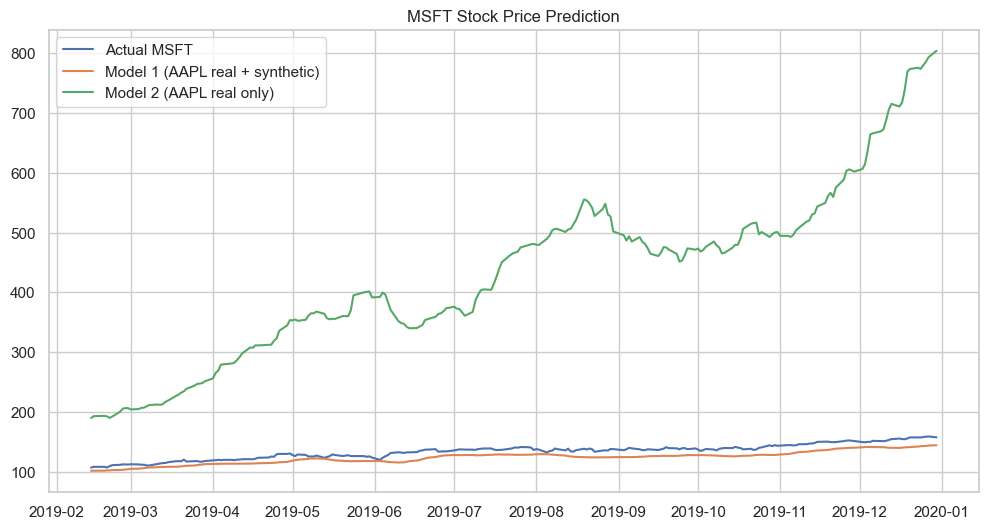

[*********************100%%**********************]  1 of 1 completed

MAE for Model 1 (AAPL real + synthetic): 10.1858
MAE for Model 2 (AAPL real only): 295.7774
RMSE for Model 1 (AAPL real + synthetic): 10.7332
RMSE for Model 2 (AAPL real only): 322.3455



C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\481783772.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\481783772.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16608\481783772.py:227: Future

MSE for Model 1 (AAPL real + synthetic): [0.0016159000806510448, 0.013812214136123657]
MSE for Model 2 (AAPL real only): [0.0029858590569347143, 0.06640317291021347]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


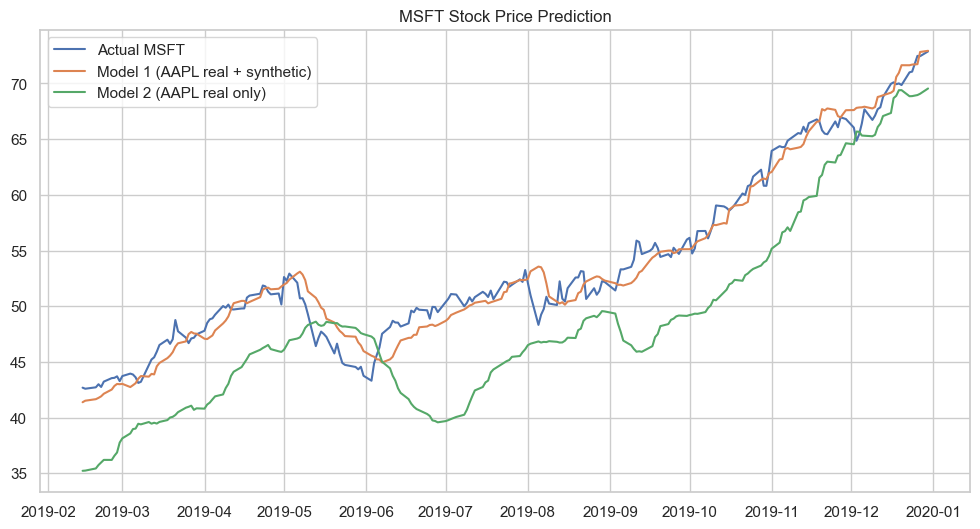

MAE for Model 1 (AAPL real + synthetic): 80.2826
MAE for Model 2 (AAPL real only): 85.3004
RMSE for Model 1 (AAPL real + synthetic): 80.5365
RMSE for Model 2 (AAPL real only): 85.5801


In [11]:

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def add_lagged_values(data, column, lags):
    for i in range(1, lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

def get_stock_data(ticker, start_date, end_date, tweets_df):
    data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = data[['Close', 'Volume']].copy()
    stock_data.columns = stock_data.columns.str.lower()  
    
    stock_data = add_lagged_values(stock_data, 'close', 5)
    
    tweets_df = tweets_df[tweets_df['ticker_symbol'] == ticker]
    tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
    combined_data = pd.merge(stock_data.reset_index(), tweets_df[['date', 'avg_negative_sentiment', 'avg_reach_per_tweet']], 
                             left_on='Date', right_on='date', how='left')
    combined_data.set_index('Date', inplace=True)
    combined_data = combined_data.drop('date', axis=1)
    
    combined_data['avg_negative_sentiment'] = combined_data['avg_negative_sentiment'].ffill()
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    combined_data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(combined_data.index, method='ffill')
    
    return combined_data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  
    return np.array(X), np.array(y)

def create_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

EPOCHS = 50

tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\volume.csv')

# Prepare AAPL data (2015-2018)
aapl_data = get_stock_data("AAPL", "2015-01-01", "2018-12-31", tweets_df)
aapl_data.dropna(inplace=True)

synthetic_data = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\csvs\synth_data_2021-02-03.csv', index_col=0, parse_dates=True)
synthetic_data.columns = synthetic_data.columns.str.lower()  # Convert to lowercase

synthetic_data = add_lagged_values(synthetic_data, 'close', 5)

# Ensure synthetic_data has the same column order as aapl_data
synthetic_data = synthetic_data[aapl_data.columns]
# synthetic_data = synthetic_data.head(400//3) #_________________________________________________________

combined_aapl_data = pd.concat([aapl_data, synthetic_data])
combined_aapl_data = combined_aapl_data.ffill().bfill()

# Prepare MSFT data (2019)
msft_data = get_stock_data("MSFT", "2019-01-01", "2019-12-31", tweets_df)

columns_to_use = ['close', 'volume', 'avg_negative_sentiment', 'avg_reach_per_tweet', 'inflation_rate', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5']
aapl_data = aapl_data[columns_to_use]
combined_aapl_data = combined_aapl_data[columns_to_use]
msft_data = msft_data[columns_to_use]
msft_data.fillna(method="ffill", inplace=True)
msft_data.fillna(method="bfill", inplace=True)

scaler = MinMaxScaler()
scaled_combined_aapl = scaler.fit_transform(combined_aapl_data)
scaled_aapl = scaler.transform(aapl_data)
scaled_msft = scaler.transform(msft_data)

seq_length = 30
X_combined_aapl, y_combined_aapl = create_sequences(scaled_combined_aapl, seq_length)
X_aapl, y_aapl = create_sequences(scaled_aapl, seq_length)
X_msft, y_msft = create_sequences(scaled_msft, seq_length)

# Model 1: Train on real AAPL (2015-2018) + synthetic data
model1 = attention((seq_length, scaled_combined_aapl.shape[1]))
model1.fit(X_combined_aapl, y_combined_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

# Model 2: Train on real AAPL (2015-2018) only
model2 = attention((seq_length, scaled_aapl.shape[1]))
model2.fit(X_aapl, y_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

# Out-of-sample testing on MSFT data (2019)
mse_model1 = model1.evaluate(X_msft, y_msft, verbose=0)
mse_model2 = model2.evaluate(X_msft, y_msft, verbose=0)

print(f"MSE for Model 1 (AAPL real + synthetic): {mse_model1}")
print(f"MSE for Model 2 (AAPL real only): {mse_model2}")

pred_model1 = model1.predict(X_msft)
pred_model2 = model2.predict(X_msft)

pred_model1 = scaler.inverse_transform(np.column_stack((pred_model1, np.zeros((pred_model1.shape[0], len(columns_to_use)-1)))))[:, 0]
pred_model2 = scaler.inverse_transform(np.column_stack((pred_model2, np.zeros((pred_model2.shape[0], len(columns_to_use)-1)))))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(msft_data.index[seq_length:], msft_data['close'].values[seq_length:], label='Actual MSFT')
plt.plot(msft_data.index[seq_length:], pred_model1, label='Model 1 (AAPL real + synthetic)')
plt.plot(msft_data.index[seq_length:], pred_model2, label='Model 2 (AAPL real only)')
plt.title('MSFT Stock Price Prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_msft = msft_data['close'].values[seq_length:]

mae_model1 = mean_absolute_error(actual_msft, pred_model1)
mae_model2 = mean_absolute_error(actual_msft, pred_model2)

rmse_model1 = np.sqrt(mean_squared_error(actual_msft, pred_model1))
rmse_model2 = np.sqrt(mean_squared_error(actual_msft, pred_model2))

print(f"MAE for Model 1 (AAPL real + synthetic): {mae_model1:.4f}")
print(f"MAE for Model 2 (AAPL real only): {mae_model2:.4f}")
print(f"RMSE for Model 1 (AAPL real + synthetic): {rmse_model1:.4f}")
print(f"RMSE for Model 2 (AAPL real only): {rmse_model2:.4f}")

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from fredapi import Fred
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

def add_lagged_values(data, column, lags):
    for i in range(1, lags + 1):
        data[f'{column}_lag_{i}'] = data[column].shift(i)
    return data

def get_stock_data(ticker, start_date, end_date, tweets_df):
    data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = data[['Close', 'Volume']].copy()
    stock_data.columns = stock_data.columns.str.lower()  
    
    stock = StockDataFrame.retype(stock_data)
    indicators = ['rsi_14', 'macd', 'boll']
    for indicator in indicators:
        stock_data[indicator] = stock[indicator]
    
    stock_data = add_lagged_values(stock_data, 'close', 5)
    
    tweets_df = tweets_df[tweets_df['ticker_symbol'] == ticker]
    tweets_df['date'] = pd.to_datetime(tweets_df['market_date'])
    combined_data = pd.merge(stock_data.reset_index(), tweets_df[['date', 'avg_negative_sentiment', 'avg_reach_per_tweet']], 
                             left_on='Date', right_on='date', how='left')
    combined_data.set_index('Date', inplace=True)
    combined_data = combined_data.drop('date', axis=1)
    
    combined_data['avg_negative_sentiment'] = combined_data['avg_negative_sentiment'].ffill()
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    combined_data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(combined_data.index, method='ffill')
    
    return combined_data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  
    return np.array(X), np.array(y)

def create_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

EPOCHS = 50

tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\volume.csv')

# Prepare AAPL data (2015-2018)
aapl_data = get_stock_data("AAPL", "2015-01-01", "2018-12-31", tweets_df)
aapl_data.dropna(inplace=True)

synthetic_data = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\csvs\synth_data_2021-02-03.csv', index_col=0, parse_dates=True)
synthetic_data.columns = synthetic_data.columns.str.lower()  # Convert to lowercase

# StockStats indicators added to synthetic data
synthetic_stock = StockDataFrame.retype(synthetic_data)
indicators = ['rsi_14', 'macd', 'boll']
for indicator in indicators:
    synthetic_data[indicator] = synthetic_stock[indicator]

synthetic_data = add_lagged_values(synthetic_data, 'close', 5)

synthetic_data = synthetic_data[aapl_data.columns]
synthetic_data = synthetic_data.head(400//3)

combined_aapl_data = pd.concat([aapl_data, synthetic_data])

combined_aapl_data = combined_aapl_data.ffill().bfill()

aapl_data_2019 = get_stock_data("AAPL", "2019-01-01", "2019-12-31", tweets_df)

columns_to_use = ['close', 'volume', 'rsi_14', 'macd', 'boll', 'avg_negative_sentiment', 'avg_reach_per_tweet', 'inflation_rate', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5']
aapl_data = aapl_data[columns_to_use]
combined_aapl_data = combined_aapl_data[columns_to_use]
aapl_data_2019 = aapl_data_2019[columns_to_use]
aapl_data_2019.fillna(method="ffill", inplace=True)
aapl_data_2019.fillna(method="bfill", inplace=True)

scaler = MinMaxScaler()
scaled_combined_aapl = scaler.fit_transform(combined_aapl_data)
scaled_aapl = scaler.transform(aapl_data)
scaled_aapl_2019 = scaler.transform(aapl_data_2019)

seq_length = 30
X_combined_aapl, y_combined_aapl = create_sequences(scaled_combined_aapl, seq_length)
X_aapl, y_aapl = create_sequences(scaled_aapl, seq_length)
X_aapl_2019, y_aapl_2019 = create_sequences(scaled_aapl_2019, seq_length)

model1 = attention((seq_length, scaled_combined_aapl.shape[1]))
model1.fit(X_combined_aapl, y_combined_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

model2 = attention((seq_length, scaled_aapl.shape[1]))
model2.fit(X_aapl, y_aapl, epochs=EPOCHS, batch_size=32, verbose=0)

mse_model1 = model1.evaluate(X_aapl_2019, y_aapl_2019, verbose=0)
mse_model2 = model2.evaluate(X_aapl_2019, y_aapl_2019, verbose=0)

print(f"MSE for Model 1 (AAPL real + synthetic): {mse_model1}")
print(f"MSE for Model 2 (AAPL real only): {mse_model2}")

pred_model1 = model1.predict(X_aapl_2019)
pred_model2 = model2.predict(X_aapl_2019)

pred_model1 = scaler.inverse_transform(np.column_stack((pred_model1, np.zeros((pred_model1.shape[0], len(columns_to_use)-1)))))[:, 0]
pred_model2 = scaler.inverse_transform(np.column_stack((pred_model2, np.zeros((pred_model2.shape[0], len(columns_to_use)-1)))))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(aapl_data_2019.index[seq_length:], aapl_data_2019['close'].values[seq_length:], label='Actual MSFT')
plt.plot(aapl_data_2019.index[seq_length:], pred_model1, label='Model 1 (AAPL real + synthetic)')
plt.plot(aapl_data_2019.index[seq_length:], pred_model2, label='Model 2 (AAPL real only)')
plt.title('MSFT Stock Price Prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_msft = msft_data['close'].values[seq_length:]

mae_model1 = mean_absolute_error(actual_msft, pred_model1)
mae_model2 = mean_absolute_error(actual_msft, pred_model2)

rmse_model1 = np.sqrt(mean_squared_error(actual_msft, pred_model1))
rmse_model2 = np.sqrt(mean_squared_error(actual_msft, pred_model2))

print(f"MAE for Model 1 (AAPL real + synthetic): {mae_model1:.4f}")
print(f"MAE for Model 2 (AAPL real only): {mae_model2:.4f}")
print(f"RMSE for Model 1 (AAPL real + synthetic): {rmse_model1:.4f}")
print(f"RMSE for Model 2 (AAPL real only): {rmse_model2:.4f}")


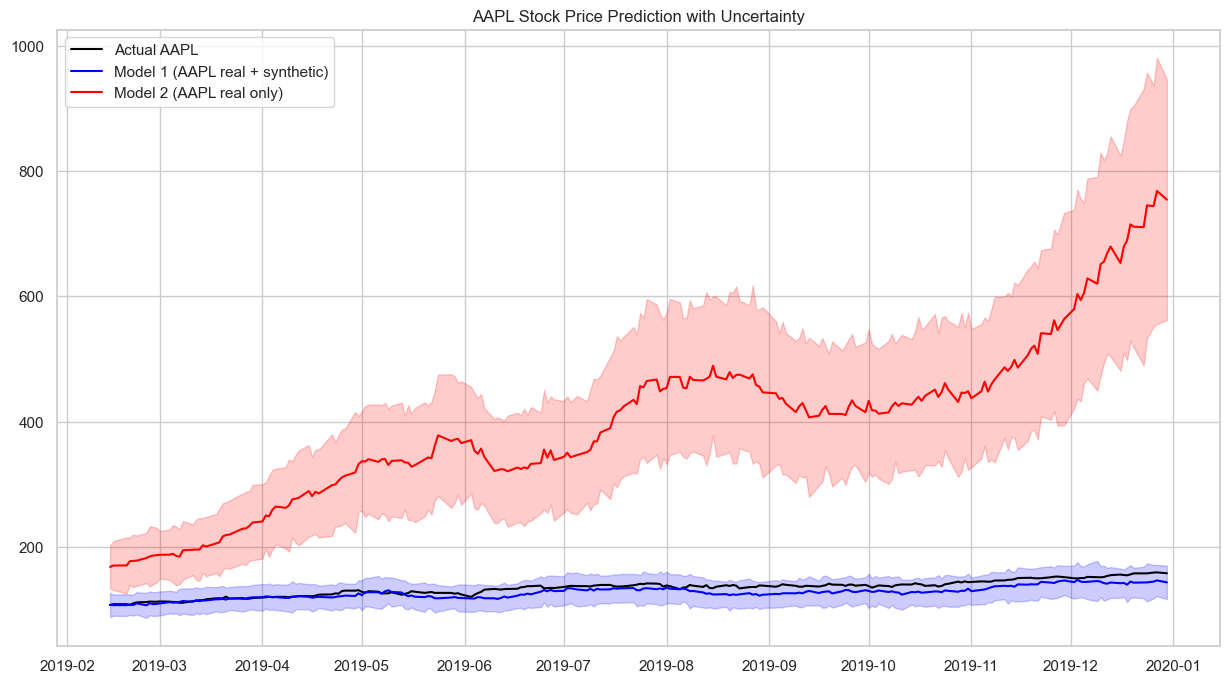

MAE for Model 1 (AAPL real + synthetic): 7.3991
MAE for Model 2 (AAPL real only): 261.7202
RMSE for Model 1 (AAPL real + synthetic): 8.7201
RMSE for Model 2 (AAPL real only): 287.0968

Mean uncertainty for Model 1: 11.2331
Max uncertainty for Model 1: 16.0869
Min uncertainty for Model 1: 8.1547

Mean uncertainty for Model 2: 51.1664
Max uncertainty for Model 2: 110.3748
Min uncertainty for Model 2: 17.1497


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


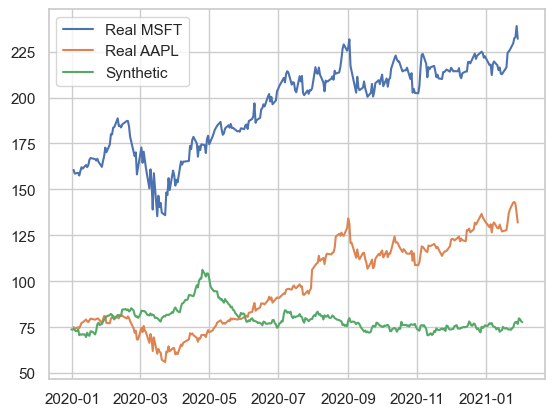

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def mc_dropout_predict(model, X, num_samples=100):
    predictions = []
    for _ in range(num_samples):
        y_pred = model(X, training=True)  # dropout during inference
        predictions.append(y_pred)
    
    y_pred_mean = np.mean(predictions, axis=0)
    y_pred_std = np.std(predictions, axis=0)
    
    return y_pred_mean, y_pred_std


# Monte Carlo predictions for Model 1
pred_mean_model1, pred_std_model1 = mc_dropout_predict(model1, X_msft)

# Monte Carlo predictions for Model 2
pred_mean_model2, pred_std_model2 = mc_dropout_predict(model2, X_msft)

pred_mean_model1 = scaler.inverse_transform(np.column_stack((pred_mean_model1, np.zeros((pred_mean_model1.shape[0], len(columns_to_use)-1)))))[:, 0]
pred_std_model1 = pred_std_model1.flatten() * (scaler.data_max_[-1] - scaler.data_min_[-1])

pred_mean_model2 = scaler.inverse_transform(np.column_stack((pred_mean_model2, np.zeros((pred_mean_model2.shape[0], len(columns_to_use)-1)))))[:, 0]
pred_std_model2 = pred_std_model2.flatten() * (scaler.data_max_[-1] - scaler.data_min_[-1])

plt.figure(figsize=(15, 8))
plt.plot(msft_data.index[seq_length:], msft_data['close'].values[seq_length:], label='Actual AAPL', color='black')

plt.plot(msft_data.index[seq_length:], pred_mean_model1, label='Model 1 (AAPL real + synthetic)', color='blue')
plt.fill_between(msft_data.index[seq_length:], 
                 pred_mean_model1 - 2*pred_std_model1, 
                 pred_mean_model1 + 2*pred_std_model1, 
                 color='blue', alpha=0.2)

plt.plot(msft_data.index[seq_length:], pred_mean_model2, label='Model 2 (AAPL real only)', color='red')
plt.fill_between(msft_data.index[seq_length:], 
                 pred_mean_model2 - 2*pred_std_model2, 
                 pred_mean_model2 + 2*pred_std_model2, 
                 color='red', alpha=0.2)

plt.title('AAPL Stock Price Prediction with Uncertainty')
plt.legend()
plt.show()

actual_msft = msft_data['close'].values[seq_length:]

mae_model1 = mean_absolute_error(actual_msft, pred_mean_model1)
mae_model2 = mean_absolute_error(actual_msft, pred_mean_model2)

rmse_model1 = np.sqrt(mean_squared_error(actual_msft, pred_mean_model1))
rmse_model2 = np.sqrt(mean_squared_error(actual_msft, pred_mean_model2))

print(f"MAE for Model 1 (AAPL real + synthetic): {mae_model1:.4f}")
print(f"MAE for Model 2 (AAPL real only): {mae_model2:.4f}")
print(f"RMSE for Model 1 (AAPL real + synthetic): {rmse_model1:.4f}")
print(f"RMSE for Model 2 (AAPL real only): {rmse_model2:.4f}")

print(f"\nMean uncertainty for Model 1: {np.mean(pred_std_model1):.4f}")
print(f"Max uncertainty for Model 1: {np.max(pred_std_model1):.4f}")
print(f"Min uncertainty for Model 1: {np.min(pred_std_model1):.4f}")

print(f"\nMean uncertainty for Model 2: {np.mean(pred_std_model2):.4f}")
print(f"Max uncertainty for Model 2: {np.max(pred_std_model2):.4f}")
print(f"Min uncertainty for Model 2: {np.min(pred_std_model2):.4f}")

import seaborn as sns 
sns.set_style('whitegrid')
aapl_data = yf.download('AAPL', start='2020-01-01', end='2021-01-31')
msft_data = yf.download('MSFT', start='2020-01-01', end='2021-01-31')
plt.plot(msft_data.index, msft_data['Close'], label='Real MSFT')
plt.plot(aapl_data.index, aapl_data['Close'], label='Real AAPL')
plt.plot(synthetic_data.index, synthetic_data['close'], label='Synthetic')
plt.legend()
plt.show()
